In [20]:
import time
import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [21]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train_folder_path = "/content/drive/MyDrive/APS360_Project/train_set_final_model"
validation_folder_path = "/content/drive/MyDrive/APS360_Project/val_set_final_model"
test_folder_path = "/content/drive/MyDrive/APS360_Project/test_set_final_model"

In [ ]:
# resize to 64 by 64 and convert to tensor
transformation = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [ ]:
train_set = datasets.ImageFolder(root=train_folder_path, transform=transformation)
val_set = datasets.ImageFolder(root=validation_folder_path, transform=transformation)
test_set = datasets.ImageFolder(root=test_folder_path, transform=transformation)
classes = train_set.classes
classes

['Capacitor', 'LED', 'Potentiometer', 'Resistor', 'Transistor']

In [ ]:
# helper functions
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def get_accuracy(model, train_loader=None, other_loader=None, train=False):
    if train:
        data = train_loader
    else:
        data = other_loader

    correct = 0
    total = 0
    for imgs, labels in data:
        #############################################
        # #To Enable GPU Usage
        # if  torch.cuda.is_available():
        #   torch.use_cuda
        #   imgs = imgs.cuda()
        #   labels = labels.cuda()
        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total


In [ ]:
def get_model(name=str, num_classes=int, dropout_rate=0.2):
  model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
  model.name = name
  num_classes = len(classes)
  model.fc =nn.Sequential(
                  nn.Dropout(dropout_rate),
                  nn.Linear(model.fc.in_features, num_classes)
  )

  if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("GPU device name:", torch.cuda.get_device_name(0))
  else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

  model = model.to(device)
  return model

In [ ]:
def normalize(value, num_classes=5):
  return value/num_classes

In [ ]:
def train_net(model, train_set, val_set, test_set, learning_rate=0.005, batch_size=16, num_epochs=15, decay=0.00015):
  if torch.cuda.is_available():
    print("GPU is avaialbe")
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")
  np.random.seed(42)
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate, weight_decay=decay)
  #learning rate scheduler
  learning_rate_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
  # migrate to deivce

  train_losses, val_losses, train_acc, val_acc = [], [], [], []
  start_time = time.time()

  # training
  for epoch in range(num_epochs):
      model.train()
      total_train_loss = 0
      number_of_train_samples = 0
      for imgs, labels in train_loader:
          if torch.cuda.is_available():
            imgs = imgs.to(device)
            labels = labels.to(device)
          out = model(imgs)             # forward pass
          loss = criterion(out, labels) # compute the total loss
          total_train_loss += normalize(loss.item()) * imgs.size(0)        # sum the losses in a batch
          number_of_train_samples += imgs.size(0)               # add one more sample count
          loss.backward()                                 # backward pass (compute parameter updates)
          optimizer.step()                                # make the updates for each parameter
          optimizer.zero_grad()                           # a clean up step for PyTorch

      model.eval()
      total_val_loss = 0
      number_of_val_samples = 0
      with torch.no_grad():
        for imgs, labels in val_loader:
            if torch.cuda.is_available():
              imgs = imgs.to(device)
              labels = labels.to(device)

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            total_val_loss += normalize(loss.item()) * imgs.size(0)        # sum the losses in a batch
            number_of_val_samples += imgs.size(0)               # add more sample count

      # compute average loss
      average_train_loss = float(total_train_loss)/(number_of_train_samples)
      average_val_loss = float(total_val_loss)/(number_of_val_samples)
      train_losses.append(average_train_loss)             # compute *average* train loss
      val_losses.append(average_val_loss)             # compute *average* val loss
      train_acc.append(get_accuracy(model, train_loader=train_loader, train=True)) # compute training accuracy
      val_acc.append(get_accuracy(model, other_loader=val_loader, train=False))  # compute validation accuracy
      print(f"Epoch {epoch + 1}: Train acc: {train_acc[-1]} | Validation acc: {val_acc[-1]} | Train loss: {train_losses[-1]} | Validation loss: {val_losses[-1]}")
      learning_rate_scheduler.step(average_val_loss)
      if epoch != num_epochs -1:
        print(f"learning rate for Epoch No. {epoch+2} is {optimizer.param_groups[0]['lr']}" )
      # Save the current model (checkpoint) to a file
      model_path = get_model_name(model.name, batch_size, learning_rate, epoch+1)
      torch.save(model.state_dict(), model_path)

  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

  # plotting
  plt.title("Losses Curve")
  plt.plot(range(1 ,num_epochs+1), train_losses, label="Training")
  plt.plot(range(1 ,num_epochs+1), val_losses, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Accurancy Curve")
  plt.plot(range(1 ,num_epochs+1), train_acc, label="Training")
  plt.plot(range(1 ,num_epochs+1), val_acc, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))


Please Note that the **losses** for both are **normalized** to between **0 and 1**

In [ ]:
model = get_model("ResNet", len(classes))
# train with a set of parameters
train_net(model, train_set, val_set, test_set, batch_size=128, num_epochs=35)

GPU is not available, using CPU


In [36]:
# get test_loader
np.random.seed(42)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)
model = get_model("ResNet", len(classes))
model_path = get_model_name("ResNet",128, 0.005, 27)
state = torch.load(model_path)
model.load_state_dict(state)
model.eval()
accuracy = get_accuracy(model, other_loader=test_loader, train=False)
print(f"the test accuracy is {accuracy}")

GPU is not available, using CPU
the test accuracy is 0.8721804511278195


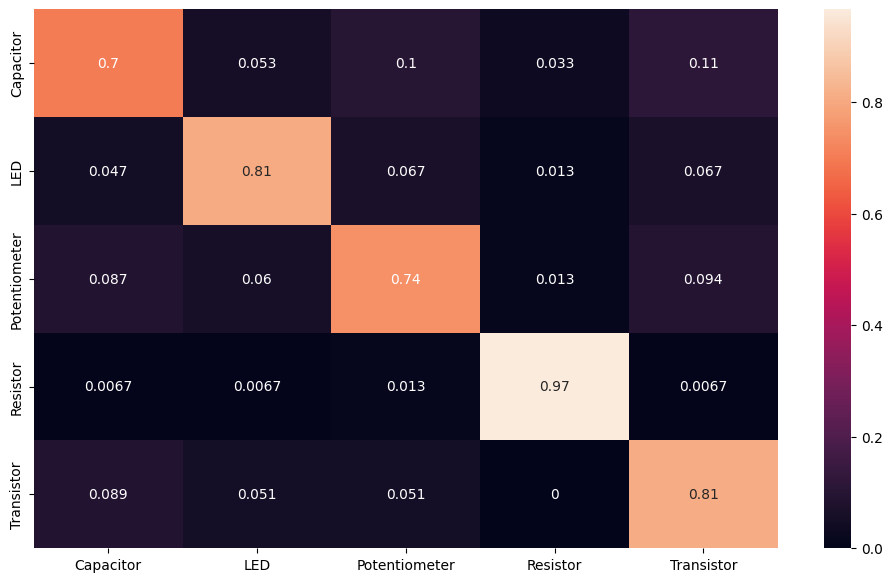

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

# on validation set
predicts = []
truth_labels = []

model.eval()
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
with torch.no_grad():
  for imgs, labels in val_loader:
      out = model(imgs)
      __, predicted = torch.max(out,1)
      predicts.extend(predicted.numpy())
      truth_labels.extend(labels.numpy())

matrix = confusion_matrix(truth_labels,predicts)

# the following code is inspired by CHristian Bernecker for his blog at https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
df_cm = pd.DataFrame(matrix / np.sum(matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
iterator = iter(test_loader)
images, labels = next(iterator)

pred_label_dict = []

while True:
  try:
      images, labels  = next(iterator)
      output = model(images)
      pred = output.max(1, keepdim=True)[1].flatten().tolist()
      labels = labels.tolist()

      # generate a dict for comparison
      for index in range(len(labels)):
        pred_label_dict.append({"predict":classes[pred[index]], "actual":classes[labels[index]]})
  except StopIteration:
      print("Iterator is empty")
      break

selections = []

for index in range(len(pred_label_dict)):
  if pred_label_dict[index]["predict"] == "BJT" or pred_label_dict[index]["predict"] == "LED" or pred_label_dict[index]["predict"] == "Capacitor" or pred_label_dict[index]["actual"] == "BJT" or pred_label_dict[index]["actual"] == "LED" or pred_label_dict[index]["actual"] == "Capacitor" :
    if pred_label_dict[index]["predict"] != pred_label_dict[index]["actual"]:
      selections.append(pred_label_dict[index])
      print(selections[-1])




Iterator is empty
{'predict': 'Capacitor', 'actual': 'LED'}
{'predict': 'Transistor', 'actual': 'LED'}
{'predict': 'Capacitor', 'actual': 'Potentiometer'}
{'predict': 'Transistor', 'actual': 'LED'}
{'predict': 'Resistor', 'actual': 'LED'}
{'predict': 'Capacitor', 'actual': 'LED'}
{'predict': 'Capacitor', 'actual': 'Potentiometer'}
{'predict': 'Potentiometer', 'actual': 'LED'}
{'predict': 'Capacitor', 'actual': 'Potentiometer'}
{'predict': 'Capacitor', 'actual': 'Potentiometer'}
{'predict': 'Transistor', 'actual': 'Capacitor'}
{'predict': 'Capacitor', 'actual': 'Transistor'}
{'predict': 'LED', 'actual': 'Potentiometer'}
{'predict': 'Capacitor', 'actual': 'Transistor'}
{'predict': 'Potentiometer', 'actual': 'Capacitor'}
{'predict': 'Transistor', 'actual': 'Capacitor'}
{'predict': 'Transistor', 'actual': 'Capacitor'}
{'predict': 'Potentiometer', 'actual': 'Capacitor'}
{'predict': 'Resistor', 'actual': 'LED'}
{'predict': 'Resistor', 'actual': 'LED'}
{'predict': 'Resistor', 'actual': 'Capac

In [37]:
unseen_test_set_path = "/content/drive/MyDrive/APS360_Project/unseen_test_set"
unseen_test_set = datasets.ImageFolder(root=unseen_test_set_path, transform=transformation)
unseen_test_loader = DataLoader(unseen_test_set, batch_size=1, shuffle=True)


pred_label_dict = []


for image, label in unseen_test_loader:
    output = model(image)
    pred = output.max(1, keepdim=True)[1].flatten().tolist()
    label = label.tolist()
    pred_label_dict.append({"predict":classes[pred[0]], "actual":classes[label[0]]})
    print(pred_label_dict[-1])



# while True:
#   try:



  #       pred_label_dict.append({"predict":classes[pred[index]], "actual":classes[labels[index]]})
  #       print(pred_label_dict[-1])
  # except StopIteration:
  #     print("Iterator is empty")
  #     break

{'predict': 'Resistor', 'actual': 'Capacitor'}
{'predict': 'LED', 'actual': 'LED'}
{'predict': 'LED', 'actual': 'LED'}
{'predict': 'Resistor', 'actual': 'Resistor'}
{'predict': 'Resistor', 'actual': 'LED'}
{'predict': 'Resistor', 'actual': 'Potentiometer'}
{'predict': 'Resistor', 'actual': 'LED'}
{'predict': 'LED', 'actual': 'LED'}
{'predict': 'Resistor', 'actual': 'Capacitor'}
{'predict': 'Resistor', 'actual': 'LED'}
{'predict': 'Resistor', 'actual': 'Capacitor'}
{'predict': 'Resistor', 'actual': 'Capacitor'}
{'predict': 'Resistor', 'actual': 'Potentiometer'}
{'predict': 'Resistor', 'actual': 'Resistor'}
{'predict': 'Resistor', 'actual': 'LED'}
{'predict': 'Resistor', 'actual': 'Resistor'}
{'predict': 'Resistor', 'actual': 'Resistor'}
{'predict': 'Resistor', 'actual': 'LED'}
{'predict': 'Resistor', 'actual': 'Capacitor'}
{'predict': 'Resistor', 'actual': 'Resistor'}
{'predict': 'Resistor', 'actual': 'Capacitor'}
{'predict': 'Resistor', 'actual': 'Resistor'}


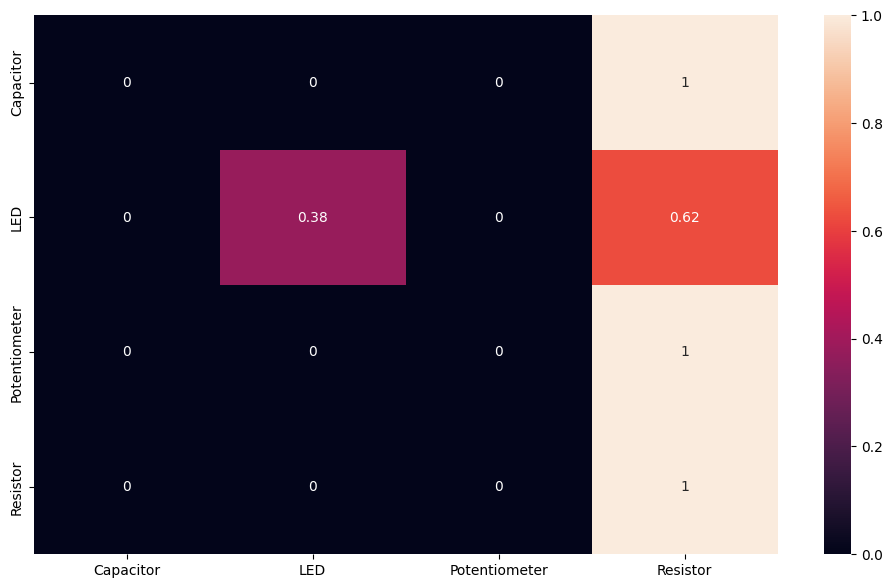

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

# on validation set
predicts = []
truth_labels = []

model.eval()
with torch.no_grad():
  for imgs, labels in unseen_test_loader:
      out = model(imgs)
      __, predicted = torch.max(out,1)
      predicts.extend(predicted.numpy())
      truth_labels.extend(labels.numpy())

matrix = confusion_matrix(truth_labels,predicts)

four_classes = classes[:4]

# the following code is inspired by CHristian Bernecker for his blog at https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
df_cm = pd.DataFrame(matrix / np.sum(matrix, axis=1)[:, None], index = [i for i in four_classes],
                     columns = [i for i in four_classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')